In [1]:
import os
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

CSV_PATH = "education_policies100_cleaned.csv"
TRAIN_PATH = "trainq1_policies.csv"
TEST_PATH = "testq1_policies.csv"

def generate_synthetic_policies(n=50):
    states = ["Karnataka","Maharashtra","Tamil Nadu","Uttar Pradesh","Delhi","Kerala","West Bengal","Gujarat","Rajasthan","Punjab"]
    sectors = ["Primary","Secondary","Higher Education","Vocational","Early Childhood"]
    target_groups = ["Students","Teachers","Rural Students","Urban Students","Women","Disadvantaged Groups","All"]
    statuses = ["Proposed","Implemented","Under Review","Pilot"]
    years = list(range(2015, 2026))
    stakeholders_list = [
        "Ministry of Education, Local NGOs",
        "State Education Department, Private Partners",
        "Teachers' Unions, Community Leaders",
        "Central Government, Donors",
        "EdTech Companies, Universities"
    ]
    funding_ranges = [(0.5,5),(5,20),(20,100),(0.1,0.5)]
    aspects = ["learning outcomes","infrastructure","teacher quality","digital access","early childhood development","vocational skills"]
    interventions = ["grants to schools","teacher training programs","digital device distribution","curriculum reform","scholarship schemes","public-private partnerships"]

    records = []
    for i in range(1, n+1):
        policy_id = f"P{1000+i}"
        title = f"{random.choice(['National','State','District'])} {random.choice(sectors)} Education Reform {random.randint(1,99)}"
        sector = random.choice(sectors)
        region = random.choice(states)
        year = random.choice(years)
        target_group = random.choice(target_groups)
        status = random.choice(statuses)
        funding = round(random.uniform(*random.choice(funding_ranges)), 2)
        stakeholders = random.choice(stakeholders_list)
        impact_score = round(random.uniform(0.1, 0.99), 3)
        summary = f"This policy aims to improve {random.choice(aspects)} in {sector} through {random.choice(interventions)} in {region}."
        goals = f"Increase reach by {random.randint(5,40)}% in {random.randint(1,5)} years."
        full_text = f"{summary} Goals: {goals}"

        records.append({
            "policy_id": policy_id,
            "title": title,
            "sector": sector,
            "region": region,
            "year": year,
            "target_group": target_group,
            "status": status,
            "funding_million_usd": funding,
            "stakeholders": stakeholders,
            "impact_score": impact_score,
            "summary": summary,
            "goals": goals,
            "full_text": full_text
        })

    return pd.DataFrame(records)

def preprocess(df):
    df = df.copy()
    # Only use columns that exist
    text_cols = [c for c in ["title", "goals"] if c in df.columns]
    df["text_for_nlp"] = df[text_cols].fillna('').agg(' '.join, axis=1).str.lower()
    return df

# Load data
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"{CSV_PATH} not found. Please provide the cleaned dataset.")
else:
    df = pd.read_csv(CSV_PATH)

# Preprocess and split
df = preprocess(df)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED, shuffle=True)

train_df.to_csv(TRAIN_PATH, index=False)
test_df.to_csv(TEST_PATH, index=False)

print(f"Data prepared: {len(train_df)} train, {len(test_df)} test.")

Data prepared: 400 train, 100 test.


In [2]:
# ==========================================
# Quantum TF-IDF Encoding using PennyLane
# ==========================================
import pandas as pd
import pennylane as qml
from pennylane import numpy as np
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer

# ---------------------------
# File Paths
# ---------------------------
MODEL_PATH = "policyq1_vectorizer.pkl"
MATRIX_PATH = "policyq1_tfidf_matrix_quantum.pkl"

# ---------------------------
# Load CSVs
# ---------------------------
train_df = pd.read_csv(TRAIN_PATH)
full_df = pd.read_csv(CSV_PATH)

# ---------------------------
# Preprocessing Function
# ---------------------------
def preprocess(df):
    # Only use columns that exist
    text_cols = [c for c in ["title", "goals"] if c in df.columns]
    if not text_cols:
        raise KeyError(f'No valid text columns found. Available columns: {df.columns.tolist()}')
    df["text_for_nlp"] = df[text_cols].fillna('').agg(' '.join, axis=1).str.lower()
    return df

# Apply preprocessing
train_df = preprocess(train_df)
full_df = preprocess(full_df)

# ---------------------------
# TF-IDF Vectorization (8 features for quantum encoding)
# ---------------------------
vectorizer = TfidfVectorizer(max_features=8, ngram_range=(1, 2))
vectorizer.fit(train_df["text_for_nlp"])

tfidf_matrix = vectorizer.transform(full_df["text_for_nlp"]).toarray()

# ---------------------------
# Quantum Amplitude Encoding
# ---------------------------

# Normalize TF-IDF vectors (amplitude encoding requires unit length)
norms = np.linalg.norm(tfidf_matrix, axis=1, keepdims=True)
normalized_vectors = tfidf_matrix / norms

# Define a 3-qubit quantum device (since 2^3 = 8 features)
n_qubits = 3
dev = qml.device("default.qubit", wires=n_qubits)

# Define quantum feature encoding circuit
@qml.qnode(dev)
def quantum_encode(vector):
    # Embed TF-IDF vector into amplitude of quantum state
    qml.AmplitudeEmbedding(vector, wires=range(n_qubits), normalize=True)
    
    # Optional: simple feature mixing layer
    qml.BasicEntanglerLayers(np.random.random((2, n_qubits)), wires=range(n_qubits))
    
    # Return final quantum state
    return qml.state()

# Encode all TF-IDF rows into quantum states
quantum_states = []
for vec in normalized_vectors:
    state = quantum_encode(vec)
    quantum_states.append(state)

quantum_states = np.array(quantum_states)

# ---------------------------
# Save Model and Data
# ---------------------------
joblib.dump(vectorizer, MODEL_PATH)
joblib.dump(
    {
        "quantum_states": quantum_states,
        "tfidf_matrix": tfidf_matrix,
        "normalized_vectors": normalized_vectors,
        "df": full_df
    },
    MATRIX_PATH
)

print(f"✅ Quantum TF-IDF encoding complete and saved to {MATRIX_PATH}")




✅ Quantum TF-IDF encoding complete and saved to policyq1_tfidf_matrix_quantum.pkl


TF-IDF matrix shape: (500, 8), Sparsity: 69.58%
Top 20 words/phrases by TF-IDF importance:
and: 196.62
education: 168.82
reform: 142.11
education reform: 142.11
to: 130.26
learning: 125.00
district: 92.80
outcomes: 74.13


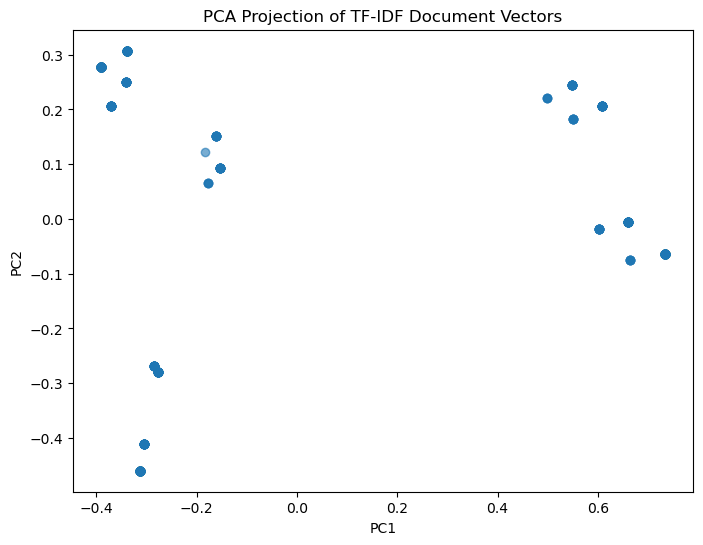

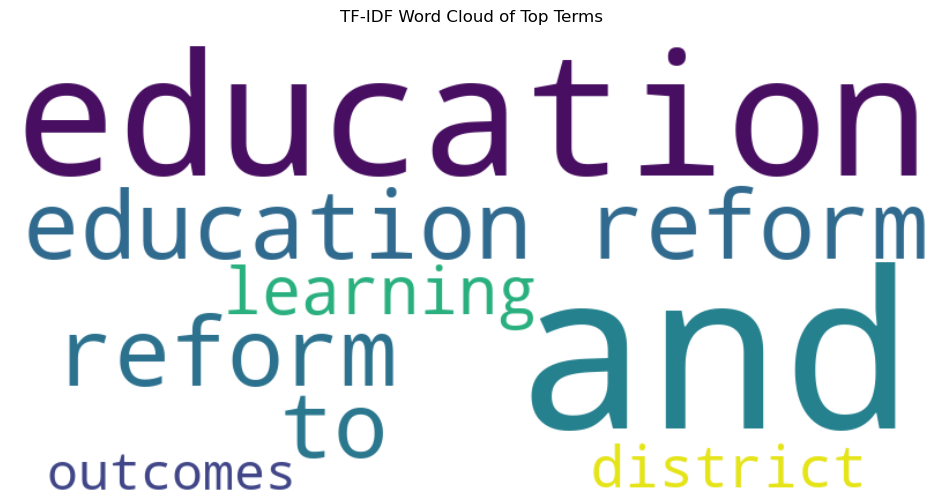

In [3]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from wordcloud import WordCloud
import numpy as np

sparsity = 100.0 * (np.count_nonzero(tfidf_matrix) / tfidf_matrix.size)
print(f"TF-IDF matrix shape: {tfidf_matrix.shape}, Sparsity: {sparsity:.2f}%")

feature_names = np.array(vectorizer.get_feature_names_out())
tfidf_sum = np.sum(tfidf_matrix, axis=0)
top_indices = tfidf_sum.argsort()[::-1][:20]
print("Top 20 words/phrases by TF-IDF importance:")
for word, score in zip(feature_names[top_indices], tfidf_sum[top_indices]):
    print(f"{word}: {score:.2f}")

# PCA projection
pca = PCA(n_components=2)
reduced = pca.fit_transform(tfidf_matrix)

plt.figure(figsize=(8,6))
plt.scatter(reduced[:,0], reduced[:,1], alpha=0.6)
plt.title("PCA Projection of TF-IDF Document Vectors")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# Wordcloud
top_words_dict = {feature_names[i]: tfidf_sum[i] for i in range(len(feature_names))}
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_words_dict)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("TF-IDF Word Cloud of Top Terms")
plt.show()




In [4]:
import pennylane as qml
from pennylane import numpy as np
import joblib

# -------------------------------
# Load saved data
# -------------------------------
MATRIX_PATH = "policyq1_tfidf_matrix_quantum.pkl"
data = joblib.load(MATRIX_PATH)

# ✅ Use correct keys
tfidf_matrix = data["tfidf_matrix"]
full_df = data["df"]

# -------------------------------
# Quantum device setup
# -------------------------------
n_features = tfidf_matrix.shape[1]   # 8 features
n_qubits = n_features
dev = qml.device("default.qubit", wires=n_qubits)

# -------------------------------
# Quantum feature map (angle encoding)
# -------------------------------
def feature_map(x):
    for i in range(n_qubits):
        qml.RY(x[i], wires=i)
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i + 1])

# -------------------------------
# Quantum kernel circuit
# -------------------------------
@qml.qnode(dev)
def kernel_circuit(x1, x2):
    feature_map(x1)
    qml.adjoint(feature_map)(x2)
    return qml.probs(wires=range(n_qubits))

# -------------------------------
# Compute quantum kernel matrix
# -------------------------------
def quantum_kernel_matrix(X):
    n = X.shape[0]
    K = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            probs = kernel_circuit(X[i], X[j])
            fidelity = probs[0]  # probability of |0...0>
            K[i, j] = fidelity
            K[j, i] = fidelity
    return K

# -------------------------------
# Normalize TF-IDF features for angle encoding
# -------------------------------
X = tfidf_matrix / np.max(tfidf_matrix) * np.pi

# -------------------------------
# Compute kernel matrix
# -------------------------------
print("⚙️ Computing quantum kernel matrix...")
quantum_kernel = quantum_kernel_matrix(X)
print("✅ Quantum kernel matrix computed. Shape:", quantum_kernel.shape)





⚙️ Computing quantum kernel matrix...
✅ Quantum kernel matrix computed. Shape: (500, 500)
✅ Quantum kernel matrix computed. Shape: (500, 500)


In [11]:
def query_policy_quantum(question, top_k=3):
    query_vec = vectorizer.transform([question.lower()]).toarray()
    # Compute similarity with quantum kernel
    sims = np.array([np.sum(kernel_circuit(query_vec[0], tfidf_matrix[i])) for i in range(tfidf_matrix.shape[0])])
    top_idx = sims.argsort()[::-1][:top_k]
    results = []
    for idx in top_idx:
        row = full_df.iloc[idx]
        snippet = str(row['title']) + '. ' + str(row['goals'])
        results.append({
            'title': row['title'],
            'goals': row['goals'],
            'similarity': float(sims[idx]),
            'summary': snippet[:250] + ('...' if len(snippet) > 250 else '')
        })
    return results

# Demo query
question = "How are teacher trainings implemented in rural schools?"
top_matches = query_policy_quantum(question, top_k=3)

for i, res in enumerate(top_matches, 1):
    print(f"{i}. {res['title']} | Score={res['similarity']:.2f}")
    print(f"Summary: {res['summary']}")

1. State Higher Education Education Reform 7 | Score=1.00
Summary: State Higher Education Education Reform 7. Increase digital access score by 12% within 1 years and reduce disparities between rural and urban areas.
2. National Early Childhood Education Reform 97 | Score=1.00
Summary: National Early Childhood Education Reform 97. Introduce technology-enabled platforms for learning continuity, improve assessment methods, and strengthen governance.
3. District Primary Education Reform 88 | Score=1.00
Summary: District Primary Education Reform 88. Train 4208 teachers, deploy tablets to schools, and set up monitoring systems to measure outcomes.
